<a href="https://colab.research.google.com/github/AndresNamm/nn_zero_to_hero/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTROUDCTION - DERIVATIVES

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def f(x):
    return 3*x**2 - 4*x + 5

In [27]:
f(3.0)

20.0

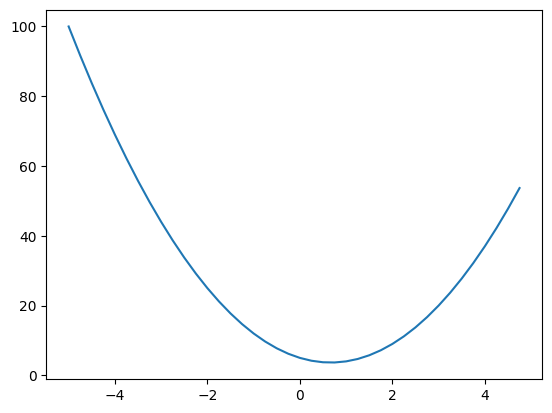

In [28]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

plot=plt.plot(xs,ys)


## DERIVATIVE OF FUNCTION

$$\frac{dy}{dx}=lim_{h->
0}\frac{f(x+h)-f(x)}{h}$$

In [29]:
h=0.0001
x=3.0
dfdx = ((f(x+h)-f(x))/h)
print(dfdx)

14.000300000063248


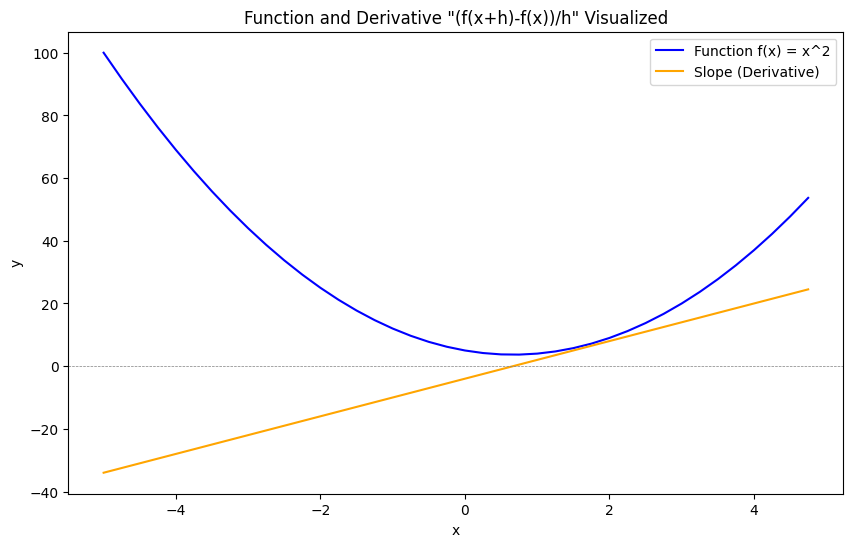

In [30]:
def slope(x,h=0.0001):
    return ((f(x+h)-f(x))/h)


xs = np.arange(-5,5,0.25)
ys = slope(xs)

ys_function = f(xs)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the function f(x)
plt.plot(xs, ys_function, label="Function f(x) = x^2", color="blue")

# Plot the slope (numerical derivative)
plt.plot(xs, ys, label="Slope (Derivative)", color="orange")

# Add title and labels
plt.title('Function and Derivative "(f(x+h)-f(x))/h" Visualized')
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color="gray", linewidth=0.5, linestyle="--")  # Add a horizontal line at y=0

# Add a legend
plt.legend()

# Display the plot
plt.show()

# MICROGRAD FRAMEWORK

Micrograd is a tiny yet powerful framework that mimics how larger machine learning libraries (like PyTorch) handle automatic differentiation. It provides an intuitive way to explore the nuances of gradient calculations.

+ Each value in MicroGrad is generated by 2 previous values and Operation that takes place between them (Similiar to Algebra actually). This approach allows to create an automatic derivative calculation function (backward) for each operation between two binary values.
+ Note on naming: In the init of Value object we are calling the predecessors of a value its children. There could be argument to say that instead the Value itself is a child to its predecessors. However if we look at this like a tree, we can also say the predecessors are Value's children (Current Approach)

In [31]:
class Value:

    def __init__(self,data, _children=(), _op='',label='',is_input=False):

        # One question, I had is why in the context of building values we name the predecessor values children. In some logic these instead could be called parents
        # This is true, but the result of micrograd, specially when calculating derivatives starts from the last value. In this way, the result looks like a tree starting from
        # The output value. Ill try to follow this context within this code.
        self.data:float = data
        self.grad:float = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.is_input = is_input
        self._gradient_updates=0

    def __repr__(self):
        return f"Value(data={self.data})"

    def get_node_label(self):

            label = f"{self.label}={self.data}" if self.label else self.data
            return "{" + f"{label} | grad={self.grad}" + " | " + f"grad_updates={self._gradient_updates}" + "}"

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out =  Value(self.data + other.data, {self,other}, _op='+')

        def _backward(): # This backward function is called from the out variable, if affects the gradients for both of its predecessors.
        # aka the result value , however the _backward function assigns gradients to input variables leveraging its own gradient #
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
            self._gradient_updates+=1
            other._gradient_updates+=1
        out._backward = _backward

        return out

    def __radd__(self,other):# https://stackoverflow.com/questions/9126766/addition-between-classes-using-radd-method
        return self+other

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, {self,other}, _op='*')

        def _backward():
            # We are adding to gradient because the value could have effect
            # through multiple later stages.
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            self._gradient_updates+=1
            other._gradient_updates+=1

        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float))

        out = Value(self.data**other,{self,},_op=f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
            self._gradient_updates+=1

        out._backward = _backward

        return out

    def __neg__(self):
        return self * (-1)

    def __sub__(self,other):
        return self + (-other)

    def __truediv__(self,other):
        return self * other**-1

    def __rmul__(self,other): # https://stackoverflow.com/questions/5181320/under-what-circumstances-are-rmul-called
        return self * other

    def tanh(self): # https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
            self._gradient_updates+=1

        out._backward = _backward
        return out

    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self,),'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
            self._gradient_updates+=1

        out._backward=_backward
        return out


    def backward(self):
        # IN A NUTSHELL
        # Assuming the approach where children are the function inputs and parent is function output. This function sorts
        # Data in order that parent gets always calculated first
        # DEEPER
        # This function is called on the final outcome of all the operations (substraction,multiplication..)
        # Implemented depth first search that tracks visited nodes.
        # It starts from root node (final result) and runs recursively build_topo function for each node in hierarcy.
        # The build_topo function finishes last for the root node so its added last to topo array.
        # Then it reverses the created topo list and calls _backward function in order
        # This way of working makes sure that we calculate the parent gradients before children gradients
        visited=set()
        topo=[]
        def build_topo(o):
            if o not in visited:
                visited.add(o)
                for node in o._prev:
                    build_topo(node)
                topo.append(o)
        self.grad=1
        build_topo(self)
        for node in reversed(topo): # Reversed makes sure that backward function starts from the last Value calculated (the result)
        # This ensures, each predecessor total gradient is calculated only after its successor gradient values have been generated
        # This is important because each values gradient is impacted by the impact it has on the successor values.
            node._backward()




a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e=a*b; e.label = 'e'
d=e+c; d.label = 'd'
f= Value(-2.0,label='f')
L = d*f; L.label = 'L'

L


Value(data=-8.0)

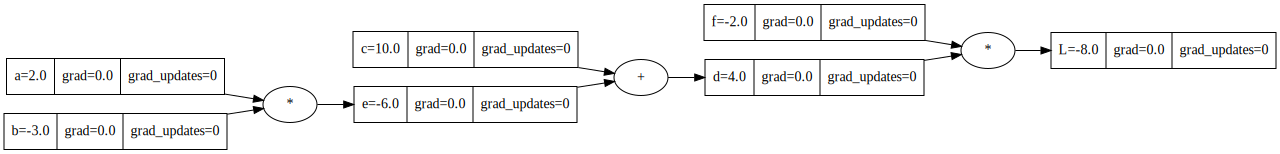

In [32]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph. Runs a DFS from the answer to all the components
  # that contributed to it.
  nodes, edges = set(), set()
  def build(v): #  DFS
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges


# Draws out all nodes and edges from set
# Adds operations as well to the picture
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    #dot.node(name = uid, label = "{ %s | data %.4f |  }" % ( n.label ,n.data), shape='record')
    if n.is_input: # If is input then color light blue
      dot.node(name = uid, label = n.get_node_label(), shape='record', color='lightblue',penwidth='2.0' )
    elif 'N_' in n.label :
      dot.node(name = uid, label = n.get_node_label(), shape='record', color='red',penwidth='2.0' )
    else:
      dot.node(name = uid, label = n.get_node_label(), shape='record')

    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

draw_dot(L)

# GRADIENT

## DOING GRADIENT CALCULATIONS IN NN EXAMPLE

In [33]:
def initialize_global_weights():
    global x1, x2, w1, w2, b, x1w1, x2w2, x1w1x2w2, n, o
    x1 = Value(2.0, label='x1', is_input=True)
    x2 = Value(0.0, label='x2', is_input=True)
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.tanh(); o.label = 'o'

initialize_global_weights()

## EXAMPLE - FINDING MANUAL GRADIENTS FOR EACH PARAMETER FOR FUNCTION O()


- leveraging [chain rule](https://www.notion.so/dataleaper/Chain-Rule-6ffc28788e9a46dc8f770dde793fda39?pvs=4)

In [34]:
o.grad = 1.0  # dO/dO = 1
o._gradient_updates = 1
# o = tanh(n)
# dO/dn = 1.0 - tanh(n)**2 = 1 - o**2
n.grad = (1.0 - o.data**2)  # derivative in o.data location
n._gradient_updates = 1
# need to leverage chain rule here to find dO/dw1
# dO/db = dO/Dn * dN/db
# dN/db = 1 -> derivative on b inside a sum is 1
b.grad = (1) * n.grad
b._gradient_updates = 1
# dO/dx1w1x2w2 = dO/dn * dN/dx1w1x2w2
# dN/dx1w1x2w2 -> derivative of x1w1x2w2 inside function b + x1w1x2w2 is 1
x1w1x2w2.grad = (1) * n.grad
x1w1x2w2._gradient_updates = 1
# dO/x1w1 = dO/dx1w1x2w2 * dX1W1X2W2/x1w1
# dX1W1X2W2/x1w1 -> derivative of x1w1 inside sum is 1
x1w1.grad = (1) * x1w1x2w2.grad
x1w1._gradient_updates = 1
# dO/x2w2 = dO/dx1w1x2w2*dX1W1X2W2/x2w2
# dX1W1X2W2/x2w2 -> derivative of x2w2 inside sum is 1
x2w2.grad = (1) * x1w1x2w2.grad
x2w2._gradient_updates = 1
# d0/w1 = dO/x1w1 * dX1W1/dw1
# dX1W1/dw1 = x1
w1.grad = (x1.data) * x1w1.grad
w1._gradient_updates = 1
# d0/w2 = dO/x2w2 * dX2W2/dw2
# dX2W2/dw2 = x2
w2.grad = (x2.data) * n.grad
w2._gradient_updates = 1
# dO/dx1 = dO/x1w1 * dX1W1/dx1
# dX1W1/dx1 = w1
x1.grad = (w1.data) * x1w1.grad
x1._gradient_updates = 1
# dO/dx2 = dO/x2w2 * dX2W2/dx2
# dX2W2/dx2 = w2
x2.grad = (w2.data) * x2w2.grad
x2._gradient_updates = 1


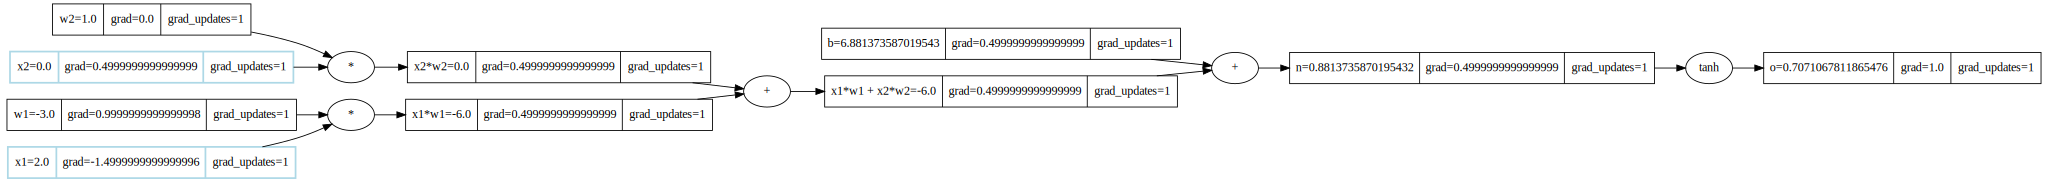

In [35]:
draw_dot(o)

# NB!

## EXAMPLE - USING _backward() FUNCTION TO FIND GRADIENTS FOR EACH PARAMETER FOR FUNCTION O()


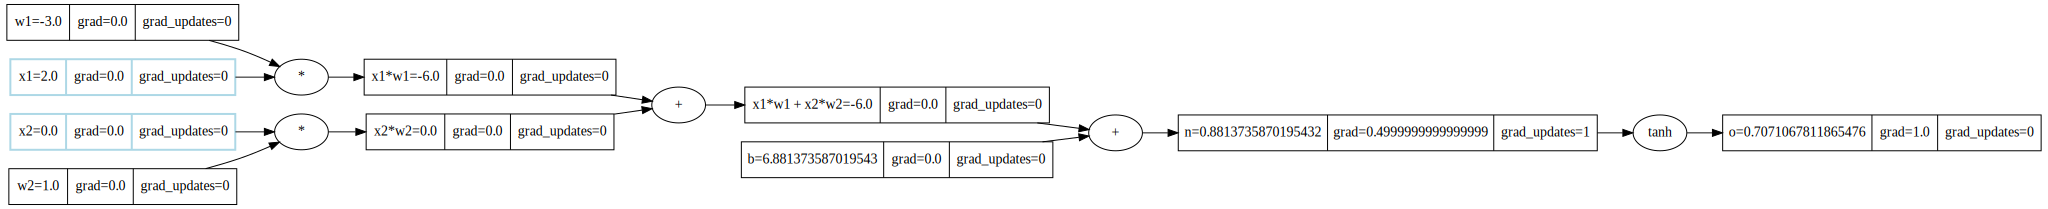

In [36]:
initialize_global_weights()
o.grad = 1.0
o._backward()
draw_dot(o) # Calculates the gradients for the input value.


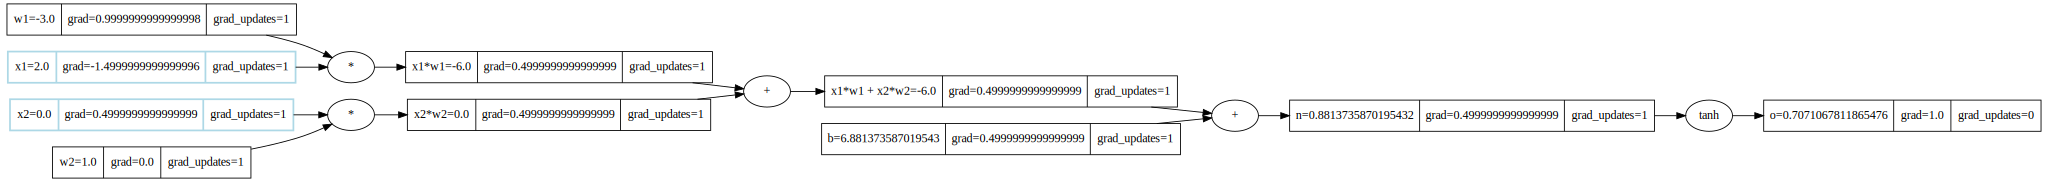

In [37]:

n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
w2._backward()
x1._backward()
x2._backward()
draw_dot(o)


## QUIZING ABOUT GRADIENT

### QUESTION  


- Why is the gradient the best direction to go when optimizing cost function?



### ANSWER

- In this case, we have first found out the partial derivative for each input variable in regards to the cost function (scalar value)
- These partial derivatives tell us the slope on each variables side.
- We are looking for the greatest combination of moving on the slopes of these parameters, e.g highest downward direction magnitude wise in regards to the cost function
- We can now think of something like choosing the best directional derivative $argmax(lim_{k->0} k \vec{x}\frac{df}{dv},\vec{x})$ where $\vec{x}$ is an unit vector in certain direction.
- The directional derivative is a dot product between vector of partial derivatives and directional vector. As $\vec{x}$ is unit vector the dot product is also a projection to the vector x. What achieves the highest projection? If two vectors move in the same direction. Aka gradient moves in the same direction as vector of partial derivatives.   
- Read more this https://www.notion.so/dataleaper/Gradient-14a2e1a674b380838a1cf121bb13ce1c

# BACKPROPAGATION

Backpropagation is an algorithm used to calculate derivatives in a neural network by using the chain rule. The idea is to aggregate all the effect (directional derivatives) a parameter has to its downstream results


## IMPLEMENTING BACKPROPAGATION WITH TOPOLOGICAL SORT

**NB!** the code is implemented as backward function above within the micrograd framework. It is heavily commented there as well.

The idea in general is that we use topological sort to implement backpropagation. The main idea is to calculate gradient for calculation results before gradient for predecessors (or we can also call them children).

1. We maintain list of visited nodes as there are many ways in NN we can get from to a certain node.
2. We get sort with DFS and reverse the outcome so we calculate gradient for nn cost function first
3. Then we call the _backward function for each Value in the abovementioned order. **By calling _backward function we update the gradients of the input parameters for the functio generating Value**




In [38]:
o.backward()

## BUGFIX

- Gradients are overwritten if one variable occurs as a dependency to multiple later variables (Like in regular NN)
- [NN zero to hero part explaining this](https://www.youtube.com/watch?v=VMj-3S1tku0&t=4948s)
- Solution: Use +=  to gradient when backwards function is called.



![](https://matthewmazur.files.wordpress.com/2018/03/neural_network-9.png)


In this example, for example we have l1 as a variable that is a dependency to h1 and h2. If we would call _backward with only = from both h1 and h2, we would
assign gradient first from h1 and then overwrite it with gradient from h2.




## BACKPROPAGATION WITH MICROGRAD

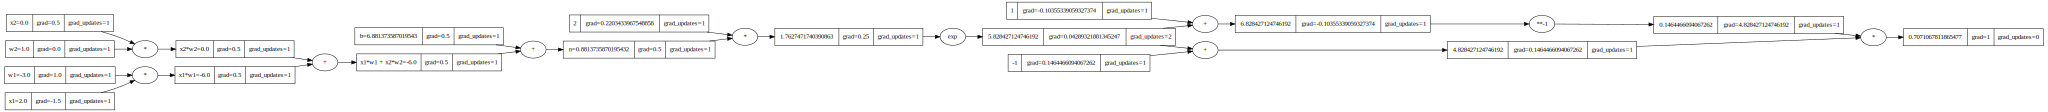

In [39]:
def initialize_global_weights_v2():
    global x1, x2, w1, w2, b, x1w1, x2w2, x1w1x2w2, n, o
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    # ----
    # o = n.tanh(); o.label = 'o'
    # instead we are going to do
    e = (2*n).exp()
    o = (e-1)/(e+1)


initialize_global_weights_v2()

o.backward()
draw_dot(o)

## BACKPROPAGATION WITH PYTHORCH

In [40]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad=True
n = x1*w1+x2*w2+b
o = torch.tanh(n)

o.backward()

print(o.data.item())

print('----')
print(f'x1: {x1.grad.item()}')
print(f'w1: {w1.grad.item()}')
print(f'x2: {x2.grad.item()}')
print(f'w2: {w2.grad.item()}')

0.7071066904050358
----
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


# BUILDING OUT A NEURAL NET

<class '__main__.Value'>
Value(data=-0.46943995357540813)


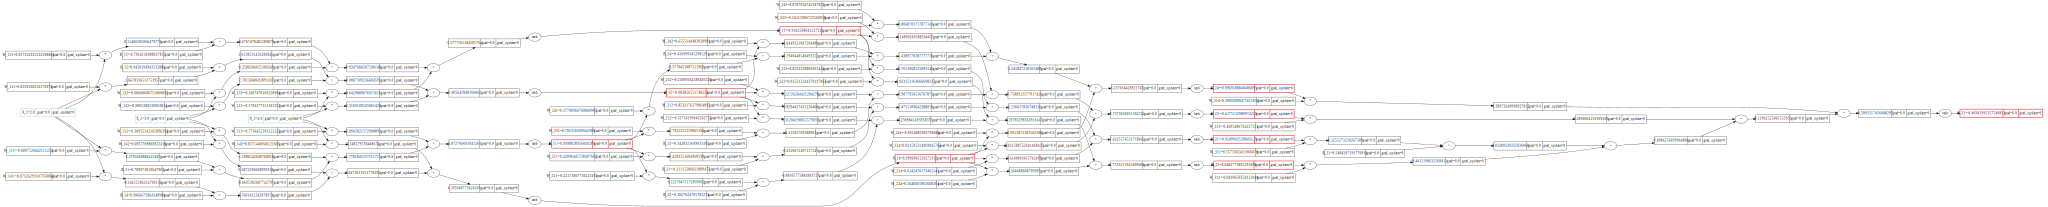

In [41]:
import random
from typing import List

# nin -- number of inputs
# nout -- number of outputs

class Neuron:
    def __init__(self,nin,layer_idx,neuron_idx):
        self.w = [Value(random.uniform(-1, 1),label=f'W_{layer_idx}{neuron_idx}{parameter_idx+1}') for parameter_idx in range(nin)]
        self.b = Value(random.uniform(-1,1),label=f'B_{layer_idx}{neuron_idx}')
        self.layer_idx = layer_idx
        self.neuron_idx = neuron_idx

    def __call__(self,x): # Returns scalar value between -1 and 1
        n = sum((xi*wi for xi,wi in zip(x,self.w)),self.b)
        tan = n.tanh(); tan.label = f'N_{self.layer_idx}{self.neuron_idx}'
        return tan

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout, layer_idx): # Input is how many inputs each neuron takes. It's the number of dimensions in
        # n-1 layer, output is how many neurons will be generated.
        self.neurons = []
        for neuron_idx in range(nout):
            self.neurons.append(Neuron(nin,layer_idx,neuron_idx+1))

    def __call__(self,x):
        out = []
        for neuron in self.neurons:
            out.append(neuron(x))

        return out[0] if len(out)==1 else out

    def parameters(self):
        return [parameter for neuron in self.neurons for parameter in neuron.parameters() ]#

class MLP:
    def __init__(self, nin:int, layers:List[int]):
        """
        nin: The size of the input vector (1 row of data)
        layers: A list where each element specifies the number of neurons in each subsequent layer.
        """

        sz = [nin]+layers
        self.layers = []
        for i in range(1, len(sz)): # generate neurons for each layer. We start from 1 not 0 index because the 0th index describes size of data
        # not neural network layer. It's needed to determine firs layer neuron size.
            # Each neuron in layer sz[i-1] inputs
            # Each layer has sz[i] neurons
            self.layers.append(Layer(sz[i-1],sz[i],i))


    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]#

x = [2.0,3.0,4.0]
x = [Value(x,label=f"X_{idx+1}", is_input=True) for idx, x in enumerate(x)]
neural_network = MLP(3,[4,4,1])
# first layer has 4 neurons each with input size of 3
# second layer has also 4 neurons each with input size of 4
# third layer has 1 neuron with input size of 4

res = neural_network(x)

print(type(res))
print(res)

draw_dot(neural_network(x))


## BACKPRPOPAGATION WITH GRADIENT DESCENT

Okay, so now we have created a neural network. It is finally time to start optimizing it.     
Optimize it for what? that is a good question. We have nothing to optimize to in this specific moment.

1. To optimize it, we need to define **training data**. And a cost function. In our example this will be multiple pairs of x and y, where x is n valued vector and y is a scalar that we want to predict based on x.
2. Next we will define cost function on top of neural network that summarizes how much NN forward pass output on top of x deviates from y.
3. Then we will define gradients for all w-s in regards to that cost function and substract gradient * learning_rate from the original w values.
    + In short, as gradient is just a collection of partial derivatives. As a whole it gives us the direction of function parameter movements in the steepest ascent. Opposite to that gives us the deepest descent. [Explanation](https://www.notion.so/dataleaper/CALCULUS-course-d74f76e4fead433a913704a584b57c79?pvs=4#be62339628e04a8fbf7cbe3dadc83174)
    + Thus moving that will give us the deepest cost reduction


For the cost function we do forward propagation with data multiple times, then we compare the result with real y and sum the differences up.

We now try to move NN params in direction so that cost function would go down. To do this we call backward on cost function.

If we have n training pairs, each parameter (w or b) has been used n times directly to get some calculation result.
** Recall that each parameter is used only within 1 neuron as multiplicator for particular input.


**NB** Important thing to take into account


- With the recursive backward methodology we are using we will calculate first parent derivatives and then child derivatives.
For child $$w_i$$, the derivative will be calculated only directly to $$\frac{dw_i}{dh}$$ and then multiplied with the total dh derivative.
It has only 1 parent thus only 1 backward call. However, $$w_i$$ will still have effect throuhgh multiple parents.
- The end result cost function is based on somethin like a sum for all training pairs. Thus with each training example we are adding to the cost function which means for each training example we will also to backpropgataion       




## WHEN YOU DO SUPERVISED TRAINING YOU CAN'T FORGET


- Cost=$\sum_0^n{(x_i-y_i)^2}$

You sum up cost for each training example.

**NB** - this example is for neural network predicting continuous values but the same logic applies for other cost functions as well.

## ONE TRAINING EXAMPLE WITH 1 FORWARD PASS

https://www.youtube.com/watch?v=KUw20-24YNE&t=124s&ab_channel=AndresNamm  -- video explaining backwards call amount.

**With 1 row of data after 1 forward pass and backpropagation**

In [42]:
x= [
    [Value(2.0,label='X_11',is_input=True),Value(3.0,label='X_12',is_input=True),Value(4.0,label='X_13',is_input=True)], # 1 row of data with 3 columns
]

y = [Value(1.0,label='Y')] # 1 outpu

neural_network = MLP(3,[4,4,1]) # initialize nn with 3 inputs that go as input to 4 neurons. A neural network with 3 layers in total.

# Run the neural network to generate output.
y_pred = [neural_network(x_i) for x_i in x] #
cost:Value = sum((y_pred_i-y_i)**2 for y_i, y_pred_i in zip(y,y_pred))# type: ignore #


print(cost)



Value(data=0.05960581968645362)


Examples

- X_11 has 4 gradient updates because it is input to 4 neurons. From each neuron we are calling the _backward function thus updating gradient for X_11 as well
- W_141 however hase only 1 update because it is input to 1 neuron and we have only 1 training example.
- N_12 will have 4 updates becaus the second layer of the neural network has 4 neurons and N_12 will be passed as one of the inputs to all of them. Thus all those outputs will have an effect on the gradient.

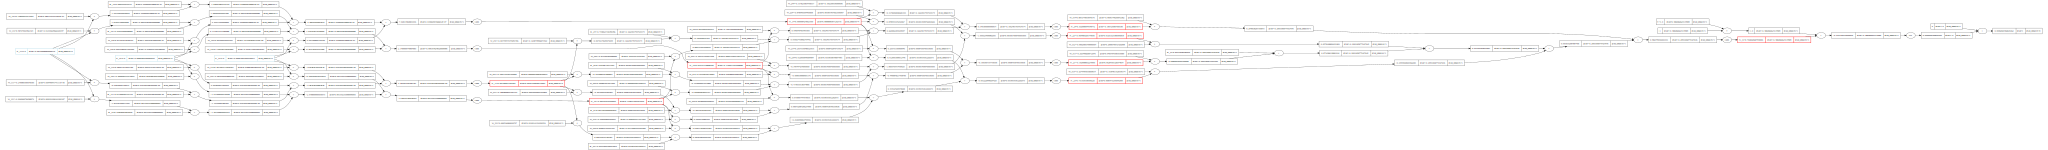

In [43]:
cost.backward()
draw_dot(cost)


## MULTIPLE TRAINING EXAMPLES

### 2 Rows of Data

With 2 rows of data we have 2 forward passes. When we call _backward from the cost function O=$\sum_0^n{(x_i-y_i)^2}$, it will trigger gradient updates for

1. $(f(x_1)-y_1)^2$
1. $(f(x_2)-y_2)^2$

Both of these are created by calling function f() which is the same neural network with same parameters thus we will updated the parameters for each forward pass aka twice.

EXAMPLES

- N_12 will still have only 4 updates but this is because N_23 represents the calculation output from forward pass which is created for each training data row separately. You will see 2 N_23 nodes on the graph below.
- X_11 will still have only 4 update but this is because its passed in forward pass to neurons only once.
- W12 will have now 2 updates - based on each training data row.

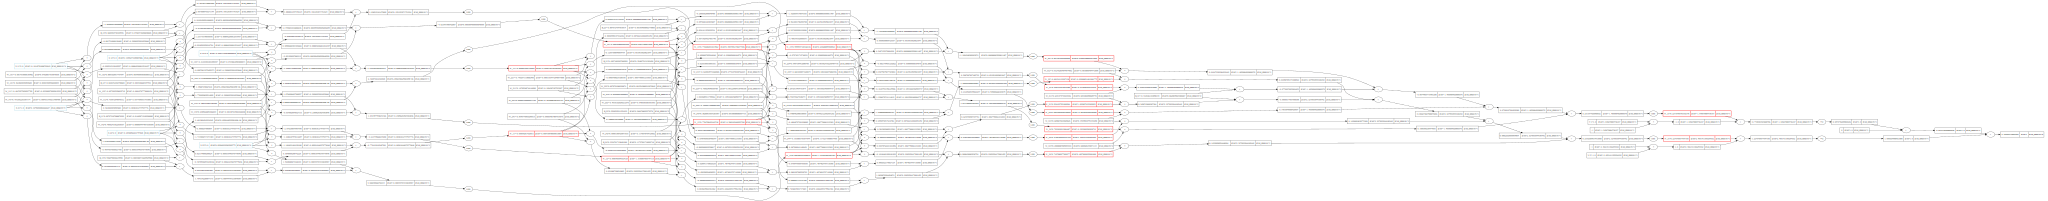

In [44]:

x= [
    [2.0,3.0,4.0],
    [1.0,2.0,3.0]
]

x = [[Value(xi,label=f'X{idx_i+1}{idxi+1}', is_input=True) for idxi,xi in enumerate(x_i)] for idx_i, x_i in enumerate(x)]


y = [1.0,-1.0]
y = [Value(yi,label=f'Y{idx+1}') for idx,yi in enumerate(y)]


neural_network = MLP(3,[4,4,1])

y_pred = [neural_network(x_i) for x_i in x] #
cost:Value = sum((y_pred_i-y_i)**2 for y_i, y_pred_i in zip(y,y_pred))# type: ignore #

cost.backward()
draw_dot(cost)

### 3 Rows of data



Below we will have 3 updates for each first layer weight because we do backtracking for each output and each weight will have effect on each forward pass.

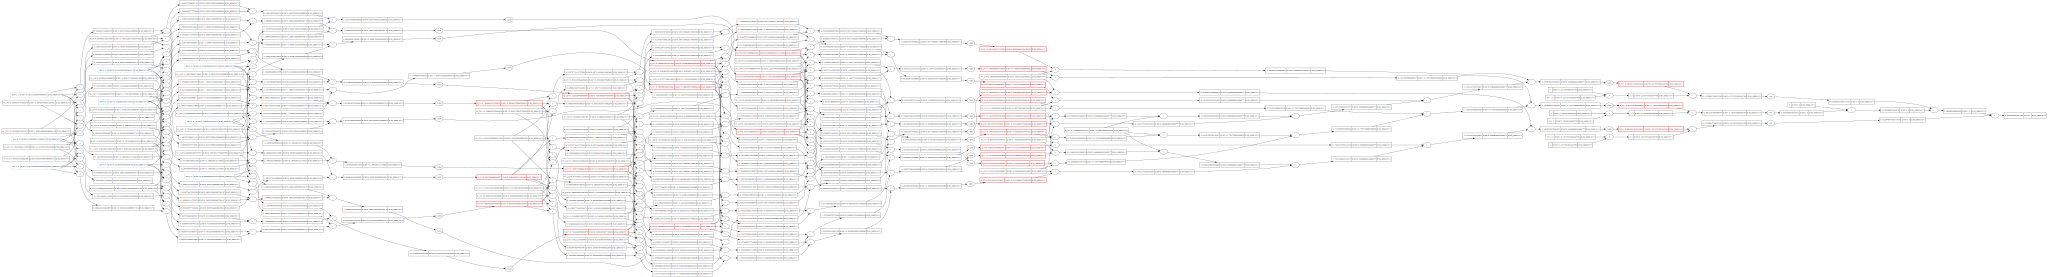

In [45]:

x= [
    [2.0,3.0,4.0],
    [1.0,2.0,3.0],
    [1.0,2.0,3.0]
]

x = [[Value(xi,label=f'X{idx_i+1}{idxi+1}', is_input=True) for idxi,xi in enumerate(x_i)] for idx_i, x_i in enumerate(x)]


y = [1.0,-1.0,-1.0]
y = [Value(yi,label=f'Y{idx+1}') for idx,yi in enumerate(y)]


neural_network = MLP(3,[4,4,1])

y_pred = [neural_network(x_i) for x_i in x] #
cost:Value = sum((y_pred_i-y_i)**2 for y_i, y_pred_i in zip(y,y_pred))# type: ignore #

cost.backward()
draw_dot(cost)

# TRAINING WITH ITERATIVE BACKPROPAGATION

## BUGGY VERSION

- Can you discover the bug without scrolling below?

In [46]:
def backpropagation(nn: MLP, x, y, trainig_rate, iterations=100):

    for i in range(iterations):
        # With each training pair we are going through, we will do 1 forward pass of the network
        y_pred=[nn(xi) for xi in x]

        # We add up the total cost. With the current approach this total cost will be the weights multiplied with
        # with all forward passes and compared with real training data. For each forward paas the cost function becomes this
        # Giant calculation #
        cost: Value =  sum([(y_i-y_pred_i)**2 for y_i,y_pred_i in zip(y_pred,y)]) # type: ignore

        # Calculate gradient for neural network parameters w-s and b-s
        cost.backward()

        #print(",".join([f"{param.label}={param.data}" for param in all_params]))
        for param in nn.parameters():
            param.data -= trainig_rate*param.grad

        print(cost)



nn = MLP(3,[4,4,1])

x= [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

x = [[Value(xi,label=f'X{idx_i+1}{idxi+1}') for idxi,xi in enumerate(x_i)] for idx_i, x_i in enumerate(x)]


y = [1.0, -1.0, -1.0, 1.0]
y = [Value(yi,label=f'Y{idx+1}') for idx,yi in enumerate(y)]

# You can try different params here
neural_network = MLP(3,[8,8,1])


backpropagation(neural_network,x,y,0.1,20)

Value(data=7.4672351835598825)
Value(data=4.676710882381623)
Value(data=7.225081680537139)
Value(data=7.928945542177856)
Value(data=7.984705868032929)
Value(data=7.993963693823383)
Value(data=7.996963743886096)
Value(data=7.998311116126514)
Value(data=7.998977289604292)
Value(data=7.999315494535354)
Value(data=7.999486454177152)
Value(data=7.9995655021463765)
Value(data=7.999586894974204)
Value(data=7.9995647324740435)
Value(data=7.9995040305308045)
Value(data=7.999408877350228)
Value(data=7.999290003080855)
Value(data=7.999168870489255)
Value(data=7.999073037415128)
Value(data=7.9990244053101)


## FIXED VERSION

- After each weight update with gradients we need to reset gradients to 0
- We need to do this because otherwise the newly calculated gradient takes into account previous directional derivative information as well. This might be wrong in the new location.

In [47]:
def backpropagation(nn: MLP, x, y, trainig_rate, iterations=100):

    for i in range(iterations):
        # With each training pair we are going through, we will do 1 forward pass of the network
        y_pred=[nn(xi) for xi in x]

        # We add up the total cost. With the current approach this total cost will be the weights multiplied with
        # with all forward passes and compared with real training data. For each forward paas the cost function becomes this
        # Giant calculation #
        cost: Value =  sum([(y_i-y_pred_i)**2 for y_i,y_pred_i in zip(y_pred,y)]) # type: ignore

        for param in nn.parameters():
            param.grad=0.0

        # Calculate gradient for neural network parameters w-s and b-s
        cost.backward()

        #print(",".join([f"{param.label}={param.data}" for param in all_params]))
        for param in nn.parameters():
            param.data -= trainig_rate*param.grad

        print(cost)



nn = MLP(3,[4,4,1])

x= [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

x = [[Value(xi,label=f'X{idx_i+1}{idxi+1}') for idxi,xi in enumerate(x_i)] for idx_i, x_i in enumerate(x)]


y = [1.0, -1.0, -1.0, 1.0]
y = [Value(yi,label=f'Y{idx+1}') for idx,yi in enumerate(y)]

# You can try different params here
neural_network = MLP(3,[8,8,1])


backpropagation(neural_network,x,y,0.1,20)

Value(data=6.069723304351642)
Value(data=7.644094601036839)
Value(data=6.229009679790721)
Value(data=6.097755206948765)
Value(data=3.5669910119388155)
Value(data=5.821825068892142)
Value(data=0.018662534231572908)
Value(data=0.013203153370382905)
Value(data=0.01029801044032307)
Value(data=0.008475979103828067)
Value(data=0.007221154031572954)
Value(data=0.006302249294361739)
Value(data=0.005599303016194136)
Value(data=0.005043648792313516)
Value(data=0.004593057727211796)
Value(data=0.004220095259062164)
Value(data=0.0039061471358407527)
Value(data=0.00363812986837506)
Value(data=0.0034065739861735608)
Value(data=0.0032044541350500426)


## TEST TRAINED NEURAL NETWORK

In [48]:
import pandas as pd

def demonstrate_predictions(nn, x, y):
    """Prints predictions and real results as a Pandas DataFrame.

    Args:
        nn: The trained neural network model.
        x: The input data.
        y: The true output values.
    """
    y_pred = [nn(x_i) for x_i in x]
    data = []
    for i in range(len(x)):
        input_data = ", ".join([str(val.data) for val in x[i]])
        prediction_val = y_pred[i].data
        real_val = y[i].data
        data.append([input_data, prediction_val, real_val])
    df = pd.DataFrame(data, columns=["Input Data", "Prediction", "Real Result"])
    return df

demonstrate_predictions(neural_network, x, y)

,Input Data,Prediction,Real Result
0,"2.0, 3.0, -1.0",0.994756,1.0
1,"3.0, -1.0, 0.5",-0.977602,-1.0
2,"0.5, 1.0, 1.0",-0.950190,-1.0
3,"1.0, 1.0, -1.0",0.995967,1.0
